In [ ]:
<script>
  jQuery(document).ready(function($) {

  $(window).load(function(){
    $('#preloader').fadeOut('slow',function(){$(this).remove();});
  });

  });
</script>

<style type="text/css">
  div#preloader { position: fixed;
      left: 0;
      top: 0;
      z-index: 999;
      width: 100%;
      height: 100%;
      overflow: visible;
      background: #fff url('http://preloaders.net/preloaders/720/Moving%20line.gif') no-repeat center center;
  }

</style>

<div id="preloader"></div>

In [ ]:
<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>

# Load the training data
Jupyter tip: Ctrl+Shift+P shows you a list of shortcut commands

In [1]:
import scipy.io as sio
rawtraining = sio.loadmat('givenData/TrainingSamplesDCT_8.mat')

# Estimate the prior probabilities the from training data
By assuming the ratio of training samples for cheetah to total training samples for background and cheetah represents the prior probability of cheetah, $P(\text{cheetah})$. The prior probability of background is then $P(\text{background})=1-P(\text{cheetah})$.

In [2]:
numtrainFG, numtrainBG = rawtraining['TrainsampleDCT_FG'].shape[0], rawtraining['TrainsampleDCT_BG'].shape[0]
priorFG = numtrainFG/(numtrainBG+numtrainFG)
priorBG = 1-priorFG

print('Number of Cheetah Training Samples:\t{0}\nNumber of Background Training Samples:\t{1}'.format(numtrainFG,numtrainBG))
print('P(cheetah)=\t{0:4.3f}\nP(background)=\t{1:4.3f}'.format(priorFG,priorBG))

# print(rawtraining.keys())
# type(rawtraining['TrainsampleDCT_FG'])
# print(rawtraining['TrainsampleDCT_FG'].shape)

Number of Cheetah Training Samples:	250
Number of Background Training Samples:	1053
P(cheetah)=	0.192
P(background)=	0.808


# Create a histogram of DCT values 
This will be used to determine the class conditional propabilities $p(\text{dct}\ |\ \text{cheetah})$ and $p(\text{dct}\ |\ \text{background})$ which are needed to calculate the Bayesian classifier $p(\text{cheetah}\ |\ \text{dct})>p(\text{background}\ |\ \text{dct}) \implies p(\text{dct}\ |\ \text{cheetah})p(\text{cheetah})>p(\text{dct}\ |\ \text{background})p(\text{background})$

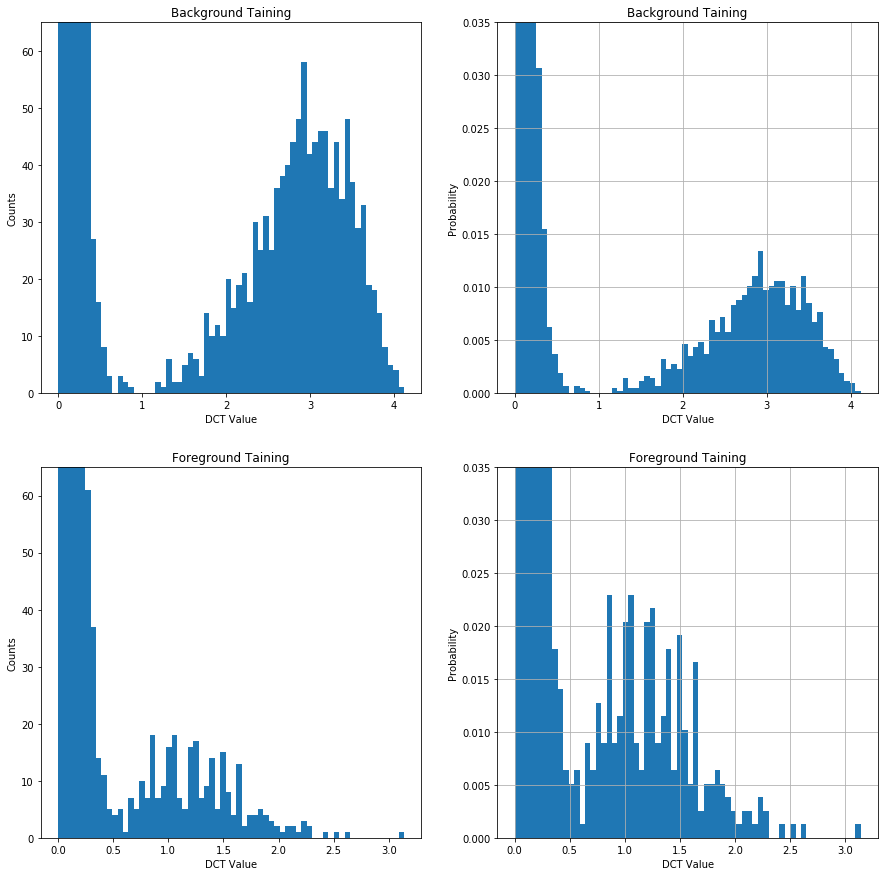

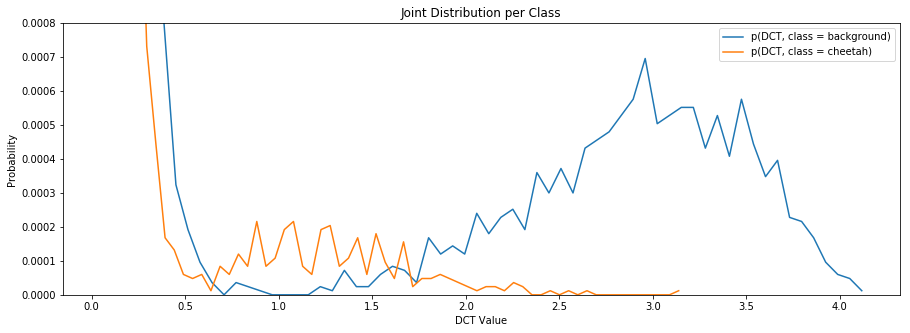

DescribeResult(nobs=16000, minmax=(0.0, 3.1387254901960779), mean=0.052550818424827728, variance=0.029996217619030981, skewness=8.053710258097745, kurtosis=75.06687135691573)
DescribeResult(nobs=67392, minmax=(0.0, 4.1176470588235281), mean=0.062183293626689437, variance=0.13349717365715991, skewness=8.115502712816335, kurtosis=66.29102494266073)


In [20]:
# %matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import describe

numbins = 64
TrainsampleDCT_BG = rawtraining['TrainsampleDCT_BG']
flatBG = np.ndarray.flatten(TrainsampleDCT_BG)

plt.figure(0, figsize=(15,15))
plt.subplot(2,2,1)
bincntsBG = plt.hist(flatBG, bins=numbins, )
plt.ylim((0,65))
plt.title(r'Background Taining')
plt.xlabel('DCT Value')
plt.ylabel('Counts')

bincntsBG = bincntsBG[0]
totalcntsBG = np.sum(bincntsBG)
probDCTgBG = bincntsBG/totalcntsBG

plt.subplot(2,2,2)
x1 = plt.hist(flatBG, bins=numbins, normed=1)
plt.ylim([0,0.035])
plt.title(r'Background Taining')
plt.xlabel('DCT Value')
plt.ylabel('Probability')
plt.grid()
# plt.legend('test')

TrainsampleDCT_FG = rawtraining['TrainsampleDCT_FG']
flatFG = np.ndarray.flatten(TrainsampleDCT_FG)

plt.subplot(2,2,3)
bincntsFG = plt.hist(flatFG, bins=numbins)
plt.ylim([0,65])
plt.title(r'Foreground Taining')
plt.xlabel('DCT Value')
plt.ylabel('Counts')

bincntsFG = bincntsFG[0]
totalcntsFG = np.sum(bincntsFG)
probDCTgFG = bincntsFG/totalcntsFG

plt.subplot(2,2,4)
x2 = plt.hist(flatFG, bins=numbins, normed=1)
plt.ylim([0,0.035])
plt.title(r'Foreground Taining')
plt.xlabel('DCT Value')
plt.ylabel('Probability')
plt.grid()
plt.show()

plt.figure(1, figsize=(15,5))
plt.plot(x1[1][1:], probDCTgBG*priorBG)
plt.plot(x2[1][1:], probDCTgFG*priorFG)
plt.title('Joint Distribution per Class')
plt.xlabel('DCT Value')
plt.ylabel('Probability')
plt.ylim([0,0.0008])
plt.legend(['p(DCT, class = background)', 'p(DCT, class = cheetah)'])
plt.show()

# plt.savefig('filename', dpi=600)
# print('Total Probability: {}'.format(np.sum(probDCTgFG)))
# print('Total Probability: {}'.format(np.sum(probDCTgBG)))
datasummary1 = describe(flatFG)
datasummary2 = describe(flatBG)
print(datasummary1)
print(datasummary2)

# Read in the grayscale image of a cheetah
Also convert from an array of integers between 0 and 255 to an array of doubles between 0 and 1 to match the training data format

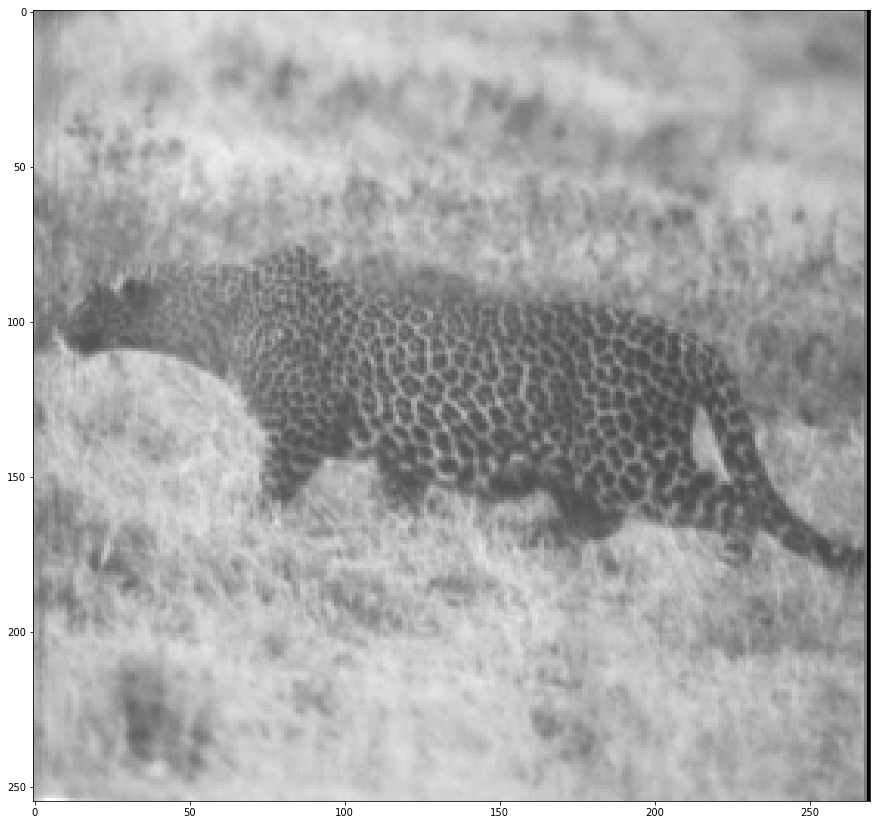

In [27]:
from scipy.misc import imread

rawimage = imread('givenData/cheetah.bmp', 'L')
plt.figure(figsize=(15,15))
plt.imshow(rawimage, cmap='gray')
plt.show()

doubleimage = rawimage.astype(float)/255 # convert from intergers 0->255 to floats 0->1

# Function to determine the 2-D discrete time transform from 1-D transforms
We need this because scipy doesn't have a direct implementation

In [28]:
def dct2(img):
    """ Get 2D Cosine Transform of Image
    """
    return dct(dct(img.T, norm='ortho').T, norm='ortho')

# Implement the classifier 
Go through the cheetah image in blocks of 8x8 pixels with a stride of 1 pixel, take the 2-D DCT of each of these blocks, take the magnitude, vectorize using the zigzag pattern given and choose the index of the second largest element. This will be the feature we use to determine cheetah vs background going forward.

# Calculate the probability of error
An error occurs when the dct value of a patch of picture corresponds to a cheetah when the patch is actually background or the dct value corresponds to background when it is actually cheetah. Let $R_1$ represent the set of all dcts corresponding to cheetah and $R_2$ the set corresponding to background based off the training data given, then

$$
\begin{align}
P(\text{error}) &= P(\text{dct}\in R_1\ ,\ \text{background})+P(\text{dct}\in R_2\ ,\ \text{cheetah}) \\
&= P(\text{dct}\in R_1 \ | \ \text{background})P(\text{background}) + P(\text{dct}\in R_2 \ | \ \text{cheetah})P(\text{cheetah}) \\
&=\sum_{n=0}^NP(\text{dct}(n)\ |\ \text{background})P(\text{background}) + \sum_{m=0}^MP(\text{dct}(m)\ |\ \text{cheetah})P(\text{cheetah}) 
\end{align}
$$

where N and M are the number of dct values in $R_1$ and $R_2$ respectively. 

In [29]:
from scipy.fftpack import dct

blksizecol = 8    # the number of horizontal pixels per block
blksizerow = 8    # the number of vertical pixels per block
dctlargest = 2    # choose this variables value largest dct from array
# priorFG = 0.5 #0.16  # lets you play with the prior if you would like
# priorBG = 1-priorFG

numrow, numcol = doubleimage.shape
cheetahmask = np.zeros((numrow,numcol))
dctflatordered = np.zeros(blksizerow*blksizecol)
for mm in range(numrow - blksizerow):
    for nn in range(numcol - blksizecol):
        block = doubleimage[mm:mm+blksizerow, nn:nn+blksizecol]
        blockdct = np.absolute(dct2(block))        
        blockdctflat = np.ndarray.flatten(blockdct)
        
        # this ordering keeps similar frequency values in contiguous array elements
        zigzagpattern = np.array([[ 0, 1, 5, 6,14,15,27,28],
                                  [ 2, 4, 7,13,16,26,29,42],
                                  [ 3, 8,12,17,25,30,41,43],
                                  [ 9,11,18,24,31,40,44,53],
                                  [10,19,23,32,39,45,52,54],
                                  [20,22,33,38,46,51,55,60],
                                  [21,34,37,47,50,56,59,61],
                                  [35,36,48,49,57,58,62,63]])
        zigzagflat = np.ndarray.flatten(zigzagpattern)
        
        # This loop does the reordering
        for ww in range(0,blksizecol*blksizerow):
            dctflatordered[zigzagflat[ww]] = blockdctflat[ww]
        
        binidx = np.argpartition(dctflatordered, -dctlargest)[-dctlargest] # get second largest
        
        # cheetahmask values should be either 0 for black pixels and 255 for white pixels
        FGorBGbigger = (probDCTgFG[binidx]*priorFG) > (probDCTgBG[binidx]*priorBG)
        cheetahmask[mm,nn] = np.array(FGorBGbigger, dtype=int)*255

# Calculate the Bayesian probability of error
pe1 = 0
pe2 = 0
FGbigger = probDCTgFG*priorFG > probDCTgBG*priorBG
for idx in range(len(FGbigger)):
    if FGbigger[idx]:
    #     pe1 = pe1 + (probDCTgBG[binidx]*priorBG)
        pe1 =+ probDCTgBG[idx]*priorBG
    else:
    #     pe2 = pe2 + (probDCTgFG[binidx]*priorFG)
        pe2 =+ probDCTgFG[idx]*priorFG

pe = pe1 + pe2

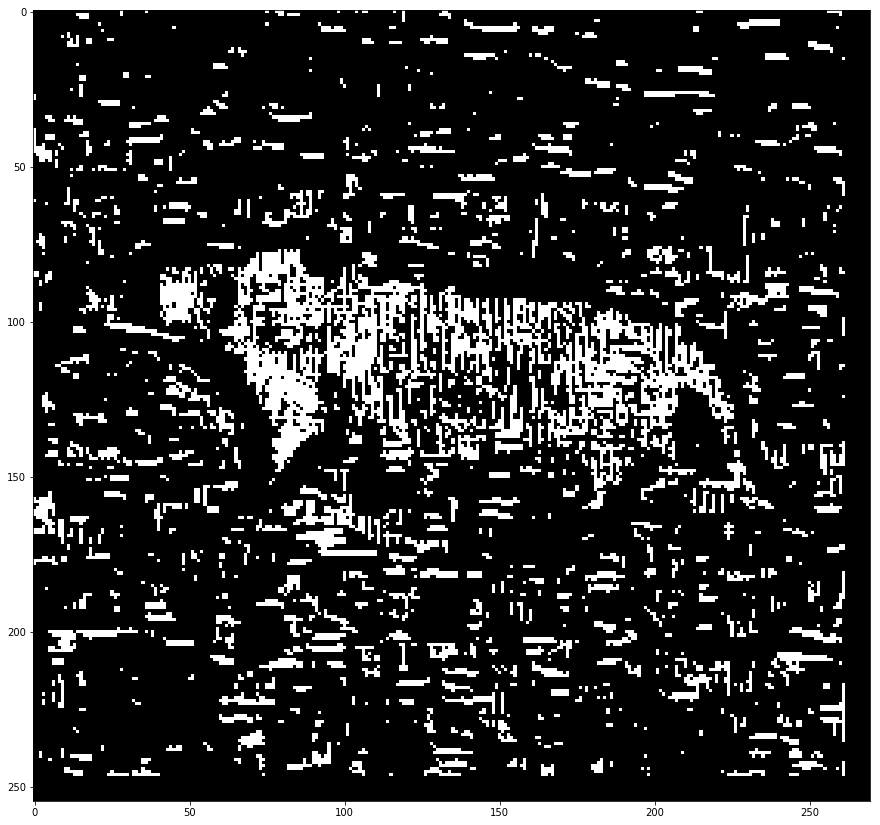

In [30]:
plt.figure(figsize=(15,15))
plt.imshow(cheetahmask, cmap='gray')
plt.show()

The above is the mask of the cheetah with white pixels denoting what the algorithm classified as cheetah and black pixels denoting background. The Bayesian error was computed to be 9.47%.

In [24]:
print(probDCTgFG*priorFG > probDCTgBG*priorBG)
print(pe*100)
print(range(len(FGbigger)))
print(kk)
print(len(probDCTgBG))
print(len(FGbigger))
print(range(len(FGbigger)))

[False False False  True False False  True False  True  True  True  True
 False  True  True  True  True  True  True  True  True  True  True  True
  True  True  True False  True False  True False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False  True]
0.00119915579432
range(0, 64)


NameError: name 'kk' is not defined

In [ ]:
import pandas as pd

x = np.random.rand(3,3)
idx = np.array([[0,1,5],[2,4,6],[3,7,8]])
idxflat = np.ndarray.flatten(idx)
xflat = np.ndarray.flatten(x)
# xflatordered = xflat[idxflat]
xflatordered = np.zeros(9)
print(xflatordered)
for nn in range(0,9):
    xflatordered[idxflat[nn]] = xflat[nn]
print('Data: \n{}\n'.format(pd.DataFrame(x).to_string(index=False,header=False)))
print('ZigZag Indices: \n{}\n'.format(pd.DataFrame(idx).to_string(index=False,header=False)))
print('Reordered Array: \n{}\n'.format(xflatordered))
print('Flattened Arrays: \n{}\n'.format(idxflat))
# print(xflat)

# x_ordered = np.zeros((1,64))
# x_ordered[idxflat] = xflat
# print(x)
# print(x_ordered)

In [ ]:
<script>
  $(document).ready(function(){
    $('div.prompt').hide();
    $('div.back-to-top').hide();
    $('nav#menubar').hide();
    $('.breadcrumb').hide();
    $('.hidden-print').hide();
  });
</script>

<footer id="attribution" style="float:right; color:#999; background:#fff;">
Richard Bell - ECE271A - HW1.
</footer>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

x = np.random.rand(3)
y = np.random.rand(3)
labels = ['a', 'b', 'c']

axis1 = plt.subplot(211)
axis2 = plt.subplot(212)

axis1.scatter(x, y)

for i, label in enumerate(labels):
    axis1.annotate(label, (x[i]+.01, y[i]))

plt.show()